## Hugging Face ASR Competition 
### Read data (SPANISH)



In [5]:
import torch

In [6]:
from transformers import AutoProcessor, AutoModelForCTC

processor = AutoProcessor.from_pretrained("jhonparra18/wav2vec2-large-xls-r-300m-spanish-custom")

model = AutoModelForCTC.from_pretrained("jhonparra18/wav2vec2-large-xls-r-300m-spanish-custom")

ImportError: cannot import name 'AutoProcessor' from 'transformers' (unknown location)

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
!pip3 install ipywidgets

In [11]:
!pip install torchaudio

In [1]:
##dependencies
!pip install ipywidgets

pip install datasets==1.13.3
pip install transformers
pip install huggingface_hub
!pip install jiwer
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html


/home/jhonparra/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/jhonparra/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 287 kB 344 kB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 215 kB/s eta 0:00:01
     |████████████████████████████████| 25.6 MB 216 kB/s eta 0:00:01
     |████████████████████████████████| 86 kB 103 kB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 136 kB/s eta 0:00:01
     |████████████████████████████████| 76 kB 204 kB/s eta 0:00:01
     |████████████████████████████████| 243 kB 79 kB/s eta 0:00:01
     |████████████████████████████████| 128 kB 77 kB/s eta 0:00:01
     |███████████████████████████

In [1]:
from datasets import load_dataset, load_metric, Audio

common_voice_train = load_dataset("common_voice", "es", split="train+validation")
common_voice_test = load_dataset("common_voice", "es", split="test")

Reusing dataset common_voice (/home/jhonparra/.cache/huggingface/datasets/common_voice/es/6.1.0/f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9)
Reusing dataset common_voice (/home/jhonparra/.cache/huggingface/datasets/common_voice/es/6.1.0/f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9)


### Exploring Dataset

Explore dataset and feature variability

In [2]:
!pip install seaborn

/home/jhonparra/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/jhonparra/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
     |████████████████████████████████| 292 kB 378 kB/s eta 0:00:01
     |████████████████████████████████| 39.3 MB 90 kB/s  eta 0:00:01
     |████████████████████████████████| 11.3 MB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 57.4 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


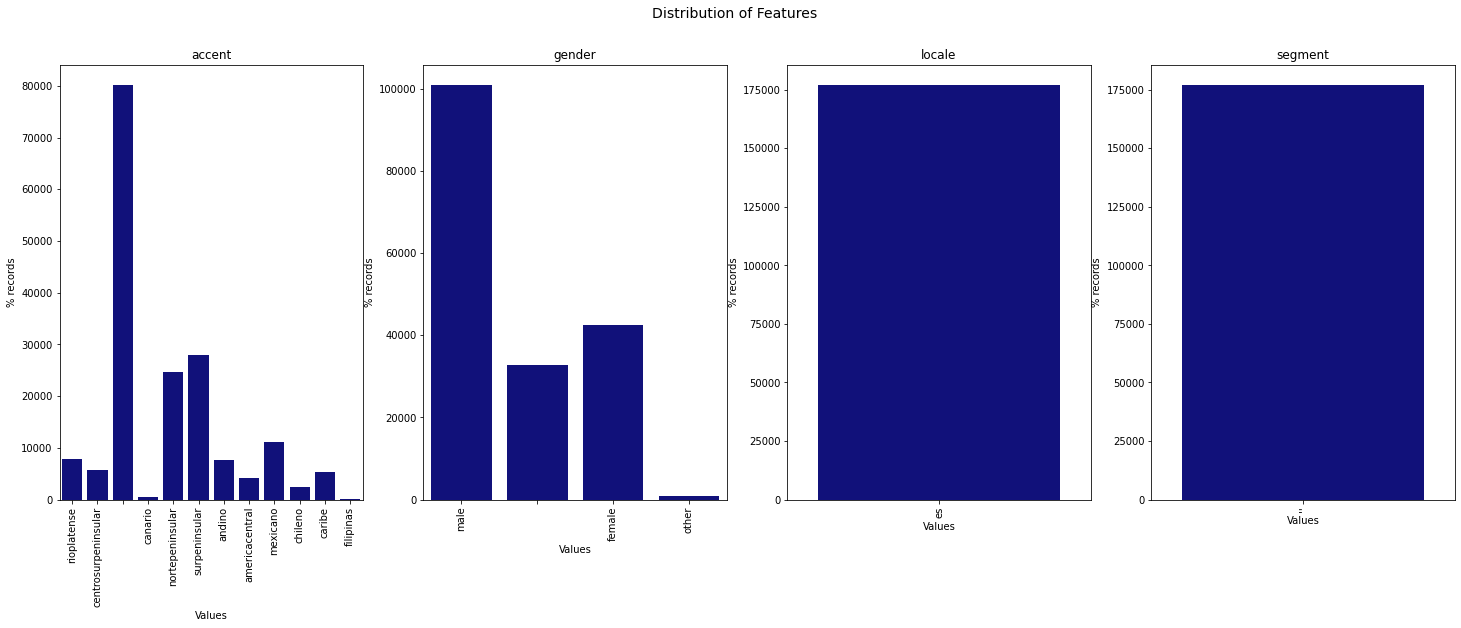

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(25,8))
columns_explore=["accent", "gender", "locale", "segment"]
for i in range(len(columns_explore)):
    datac=common_voice_train[columns_explore[i]]
    ax=fig.add_subplot(1,4,i+1)
    sns.countplot(x=datac,color="darkblue",ax=ax)
    ax.set_ylabel("% records")
    ax.set_xlabel("Values")
    ax.set_title(columns_explore[i])
    plt.xticks(rotation=90);
fig.suptitle("Distribution of Features",size=14);

In [3]:
common_voice_train = common_voice_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])

In [4]:
### cleaning text auxiliar functions
import re
def clean_batch(batch):
    batch["sentence"] = re.sub("([^A-Za-zÀ-ú ])", '', batch["sentence"]).lower()
    batch["sentence"]= re.sub("([ß|þ|ð|æ])",'',batch['sentence'])
    return batch

def homologate_accents(batch):
    batch["sentence"]=re.sub("([â|ã|ä|å|à])","a",batch["sentence"])
    batch["sentence"]=re.sub("([é|ê|ë])","e",batch["sentence"])
    batch["sentence"]=re.sub("([ì|î|ï])","i",batch["sentence"])
    batch["sentence"]=re.sub("([ö|õ|ô|ò|ø])","o",batch["sentence"])
    batch["sentence"]=re.sub("ù","u",batch["sentence"])
    batch["sentence"]=re.sub("ç","c",batch["sentence"])
    
    return batch

In [5]:
##apply it for every audio

common_voice_train = common_voice_train.map(clean_batch)
common_voice_train = common_voice_train.map(homologate_accents)
common_voice_test = common_voice_test.map(clean_batch)
common_voice_test = common_voice_test.map(homologate_accents)

  0%|          | 0/176902 [00:00<?, ?ex/s]

  0%|          | 0/176902 [00:00<?, ?ex/s]

Loading cached processed dataset at /home/jhonparra/.cache/huggingface/datasets/common_voice/es/6.1.0/f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9/cache-e016e149bb70efac.arrow
Loading cached processed dataset at /home/jhonparra/.cache/huggingface/datasets/common_voice/es/6.1.0/f7a9d973839b7706e9e281c19b7e512f31badf3c0fdbd21c671f3c4bf9acf3b9/cache-3995c6dd43698d78.arrow


### Generate Vocabulary

In [6]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [7]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
print(vocab_dict)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'á': 27, 'í': 28, 'ñ': 29, 'ó': 30, 'ú': 31}


In [9]:
## add a special character for empty value
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [10]:
##add unknown and padding tokens
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

34

In [8]:
!pip3 install transformers

In [11]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [9]:
from transformers import Wav2Vec2CTCTokenizer
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

ModuleNotFoundError: No module named 'transformers.models'

### Upload Tokenizer to Repo

In [30]:
repo_name = "wav2vec2-large-xls-r-300m-spanish-small"
tokenizer.push_to_hub(repo_name)

### Model Definition

In [13]:

from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [14]:
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [15]:
##convert to 16000 hz
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16000))

In [16]:
##listen to random audio and its text
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(common_voice_train)-1)

print(common_voice_train[rand_int]["sentence"])
ipd.Audio(data=common_voice_train[rand_int]["audio"]["array"], autoplay=True, rate=16000)

teotihuacán es una ciudadtemplo sin murallas


In [17]:
rand_int = random.randint(0, len(common_voice_train)-1)

print("Target text:", common_voice_train[rand_int]["sentence"])
print("Input array shape:", common_voice_train[rand_int]["audio"]["array"].shape)
print("Sampling rate:", common_voice_train[rand_int]["audio"]["sampling_rate"])

Target text: se dedicó a la narrativa desde su juventud
Input array shape: (62208,)
Sampling rate: 16000


In [21]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=16000).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [22]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

  0%|          | 0/176902 [00:00<?, ?ex/s]

  0%|          | 0/15089 [00:00<?, ?ex/s]

In [25]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [24]:
wer_metric = load_metric("wer")
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Downloading:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

In [26]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "jhonparra18/wav2vec2-large-xls-r-300m-spanish-custom", 
    attention_dropout=0.0,
     hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

model.freeze_feature_extractor()

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['quantizer.codevectors', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.bias', 'project_q.weight', 'project_hid.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it 

In [35]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=8,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=30,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=400,
  eval_steps=400,
  logging_steps=400,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  push_to_hub=True,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/jhonparra/.local/lib/python3.8/site-packages/huggingface_hub/hf_api.py:715: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/jhonparra18/wav2vec2-large-xls-r-300m-spanish-custom into local empty directory.
Using amp fp16 backend


In [36]:
trainer.train()
trainer.push_to_hub()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length.


## Conclusions

- Preprocessing steps for audio take about 30 minutes to complete
- Training time  